In [1]:
# Tại bên này có nhiều version, bỏ qua
import sys
print(sys.executable)
assert str(sys.executable) == 'C:\\Users\\user\\AppData\\Local\\Programs\\Python\\Python38\\python.exe'

In [2]:
import datetime
from datetime import date
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from requests_html import HTML
import time

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import statsmodels.api as sm
import os.path
import numpy as np
import math


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 1. Get data with Crawler

In [3]:
row_id = []
for i in range(1, 21):
    if i%2: row_id.append(str(i).zfill(2) + '_')
    else: row_id.append(str(i).zfill(2) + '_alt')

def get_stock_data(stock_symbol, output_file):
    url = 'https://s.cafef.vn/Lich-su-giao-dich-' + stock_symbol + '-1.chn'    
    
    file = open(output_file, 'w', encoding='utf-8')
    file.write(f'Date,Open,High,Low,Close\n')

    driver = webdriver.Chrome(executable_path='./chromedriver.exe')
    driver.get(url)
    html = HTML(html=driver.page_source)

    while True:        
        for i in row_id:
            html = HTML(html=driver.page_source)
            row = html.find('tr#ctl00_ContentPlaceHolder1_ctl03_rptData2_ctl' + i + 'itemTR', first=True)
            if row:                
                date = row.find('td.Item_DateItem', first=True).text
                date = pd.to_datetime(date, format='%d/%m/%Y').strftime('%Y-%m-%d')
                
                prices = row.find('td.Item_Price10')
                op, hi, lo, cl = prices[5].text, prices[6].text, prices[7].text, prices[1].text
                file.write(f'{date},{op},{hi},{lo},{cl}\n')

        button = driver.find_elements(By.LINK_TEXT, '>')
        if len(button) > 0:
            button[0].click()
            time.sleep(1)
        else:
            break

    file.close()

In [4]:
stock = ['BVH', 'SSI', 'HDG']

In [5]:
for symbol in stock:
    if not os.path.isfile(symbol+'.csv'):
        get_stock_data(symbol, symbol+'.csv')
    else:
        print('File', symbol+'.csv', 'existed')

File BVH.csv existed
File SSI.csv existed
File HDG.csv existed


## Visualize

In [6]:
def plot_stock(df, symbol):
    plt.figure(figsize = (18,7))
    plt.plot(df['Close'])
    plt.title(symbol)
    plt.xlabel('Date',fontsize=14)
    plt.ylabel('Close Price',fontsize=14)

    plt.show()
    
def plot_train_and_validation(train_data, valid_data, predictions, title=''):
    valid_vs_prediction = pd.DataFrame(valid_data)
    valid_vs_prediction['Predicted'] = scaler.inverse_transform(predictions) #Từ scaled -> giá trị cũ
    valid_vs_prediction
    
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(train_data)
    plt.plot(valid_vs_prediction[['Close', 'Predicted']])
    plt.legend(['Train', 'Val', 'Predicted'], loc='lower right')
    plt.show()
    
def plot_prediction(valid_data, predictions, next_predict, show=None, title=''):
    valid_vs_prediction = pd.DataFrame(valid_data)
    valid_vs_prediction['Predicted'] = scaler.inverse_transform(predictions) #Từ scaled -> giá trị cũ
    valid_vs_prediction
    
    plt.figure(figsize=(16,8))
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    if show==None or show > len(valid_data): show = 0
    plt.plot(valid_vs_prediction[['Close', 'Predicted']][-show:])
    plt.plot(next_predict)
    plt.legend(['Val', 'Predicted', 'Prediction'], loc='lower right')
    plt.show()

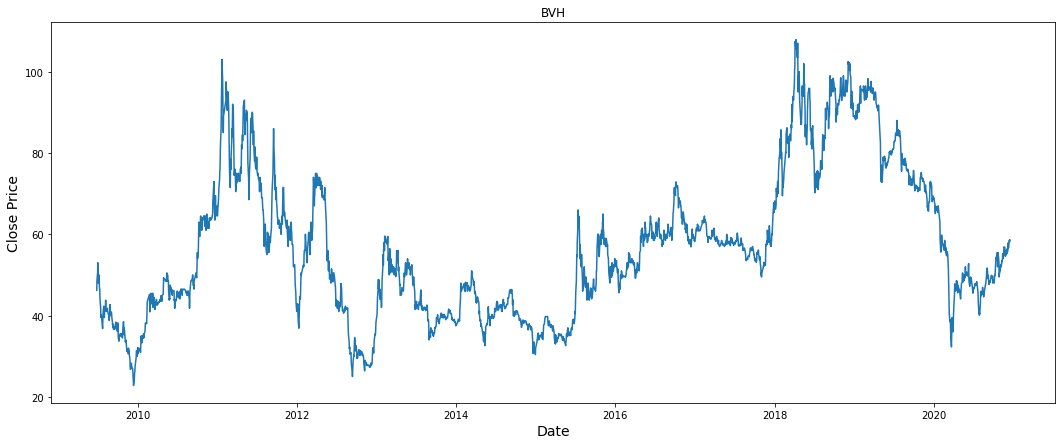

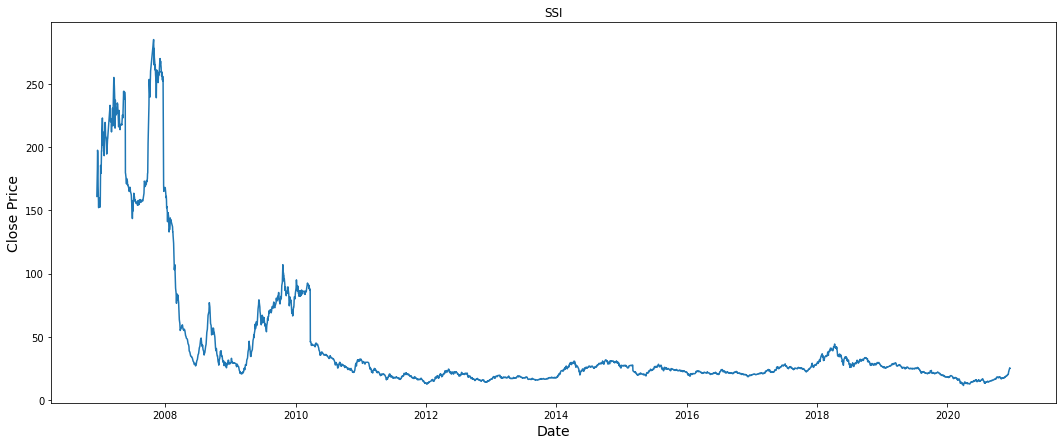

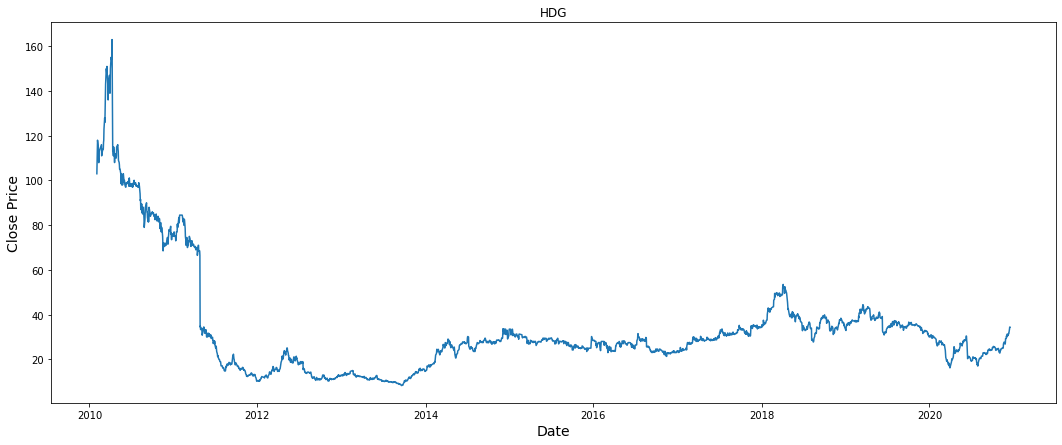

In [7]:
for symbol in stock:
    df = pd.read_csv(symbol+'.csv', parse_dates={'Datetime':['Date']}).iloc[::-1]
    df.set_index(['Datetime'], inplace = True) 
    plot_stock(df, symbol)

# 2. Preprocess

In [8]:
def fill_time_point(dataframe):
    df = dataframe.copy()
    
    i = 0
    curr = df.index[0]
    end = df.index[-1]

    while curr != end:
        curr += datetime.timedelta(days=1)
        i+=1
        if curr != df.index[i]:
            before = df.iloc[i-1].to_numpy().copy()
            after = df.iloc[i].to_numpy().copy()
            days_missed = (df.index[i] - curr).days
            avg = ((after - before)/(days_missed+1)).round(1)

            while curr != df.index[i]:
                before += avg
                fix = pd.DataFrame({'Open': before[0], 'High': before[1], 'Low': before[2], 'Close': before[3]}, index=[curr])
                df = df.append(fix)
                #print(fix)
                curr += datetime.timedelta(days=1)

    df.sort_index(inplace=True)
    return df

In [9]:
def read_the_fill_csv(filepath):
    df = pd.read_csv(filepath, parse_dates={'Datetime':['Date']}).iloc[::-1]
    df.set_index(['Datetime'], inplace = True)
    df_filled = fill_time_point(df)
    
    return df, df_filled

In [10]:
BVH, BVH_filled = read_the_fill_csv('BVH.csv')
BVH.shape, BVH_filled.shape

((2868, 4), (4193, 4))

In [ ]:
BVH

In [ ]:
BVH.dtypes

In [11]:
BVH_filled

,Open,High,Low,Close
2009-06-25,46.2,46.2,45.0,46.2
2009-06-26,48.5,48.5,48.0,48.5
2009-06-27,49.2,49.2,48.8,49.2
2009-06-28,49.9,49.9,49.6,49.9
2009-06-29,50.5,50.5,50.5,50.5
...,...,...,...,...
2020-12-12,57.1,58.1,56.4,57.9
2020-12-13,57.5,58.7,56.8,58.3
2020-12-14,58.0,59.4,57.3,58.6
2020-12-15,58.6,59.4,58.0,58.2


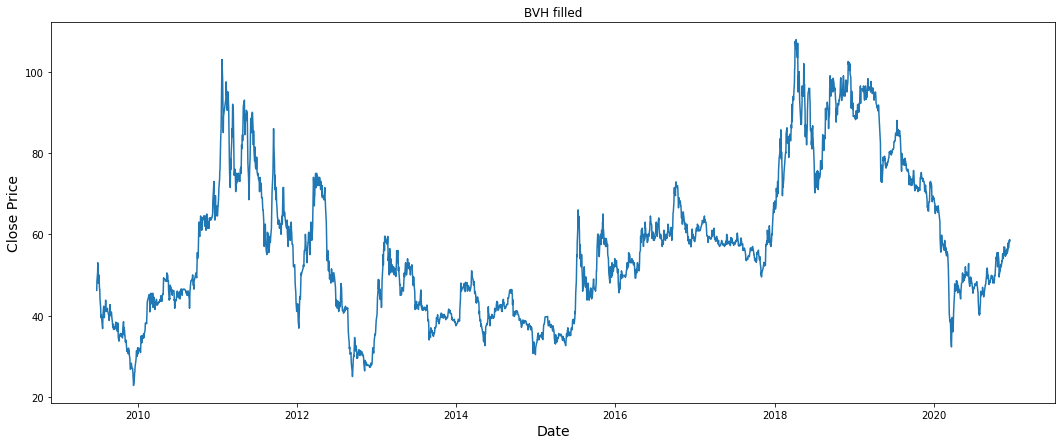

In [12]:
from datetime import date, timedelta
available = BVH.index
date_set = set(available[0] + timedelta(x) for x in range((available[-1] - available[0]).days))
missing = sorted(date_set - set(available))

In [ ]:
available_df = BVH.reindex(date_set).sort_index()
missing_df = BVH_filled.loc[missing].reindex(date_set).sort_index()

In [ ]:
fig, axes = plt.subplots(figsize=(18, 6))

ax1 = available_df['Close'].plot(label='Available data')
ax1.legend(fontsize=12)

ax2 = missing_df['Close'].plot(color='red', label='Missing data')
ax2.legend(fontsize=12)

fig.suptitle('BVH Close Price', fontsize=15)
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(18, 6))

ax1 = available_df.head(500)['Close'].plot(label='Available data')
ax1.legend(fontsize=12)

ax2 = missing_df.head(500)['Close'].plot(color='red', label='Missing data')
ax2.legend(fontsize=12)

fig.suptitle('BVH Close Price in the first 500 days', fontsize=15)
plt.show()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(BVH_filled['Close'], model = 'additive')
fig = decomposition.plot()
fig.suptitle('BVH Close Price Decomposition', fontsize=20)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=100)
plot_acf(BVH_filled['Close'].values.tolist(), lags=50, ax=axes[0])
plot_pacf(BVH_filled['Close'].values.tolist(), lags=50, ax=axes[1])
plt.show()

# 3. Forecasting

## Scaling and split data

In [13]:
def scale_and_split_data(data, train_ratio, time_window):
    split_threshold = math.ceil(len(data)*train_ratio)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(data.to_numpy().reshape(-1, 1))
    
    scaled_train = scaled_data[:split_threshold]
    scaled_test = scaled_data[split_threshold - time_window:] # Test cần lấy n ngày trước để tạo x_test cho valid[0]
    
    # x_train and y_train datasets
    x_train = []
    y_train = []

    for i in range(time_window, len(scaled_train)):
        x_train.append(scaled_train[i-time_window:i,0])
        y_train.append(scaled_train[i,0])
        #if i == time_window + 1:
            #print(x_train)
            #print(y_train)

    x_train = np.reshape(np.array(x_train), (len(x_train), time_window, 1))
    y_train = np.array(y_train)
    
    # x_test and y_test datasets
    x_test = []
    y_test =  scaled_data[split_threshold:]
    for i in range(time_window, len(scaled_test)):
        x_test.append(scaled_test[i-time_window:i,0])

    x_test = np.reshape(np.array(x_test), (len(x_test), time_window, 1))

    x_test.shape, y_test.shape
    
    # validation
    train_data = data[:split_threshold]
    valid_data = data[split_threshold:]
    
    return scaler, x_train, y_train, x_test, y_test, train_data, valid_data

In [14]:
ratio = 0.8
time_window = 100

scaler, x_train, y_train, x_test, y_test, train_data, valid_data = scale_and_split_data(BVH_filled['Close'], ratio, time_window)

In [28]:
x_train.shape, y_train.shape

((3255, 100, 1), (3255,))

## Build LSTM model

In [15]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

### Train model

In [25]:
history = model.fit(x_train, y_train, batch_size=1, verbose=2, epochs=5)

Epoch 1/5
3255/3255 - 96s - loss: 2.8113e-04
Epoch 2/5
3255/3255 - 97s - loss: 2.7449e-04
Epoch 3/5
3255/3255 - 96s - loss: 2.7780e-04
Epoch 4/5
3255/3255 - 97s - loss: 2.7828e-04
Epoch 5/5
3255/3255 - 97s - loss: 2.6677e-04


In [27]:
history.history

{'loss': [0.0002811336889863014,
  0.00027448858600109816,
  0.00027779900119639933,
  0.0002782846859190613,
  0.00026676576817408204]}

## Validation

In [17]:
predictions = model.predict(x_test) 

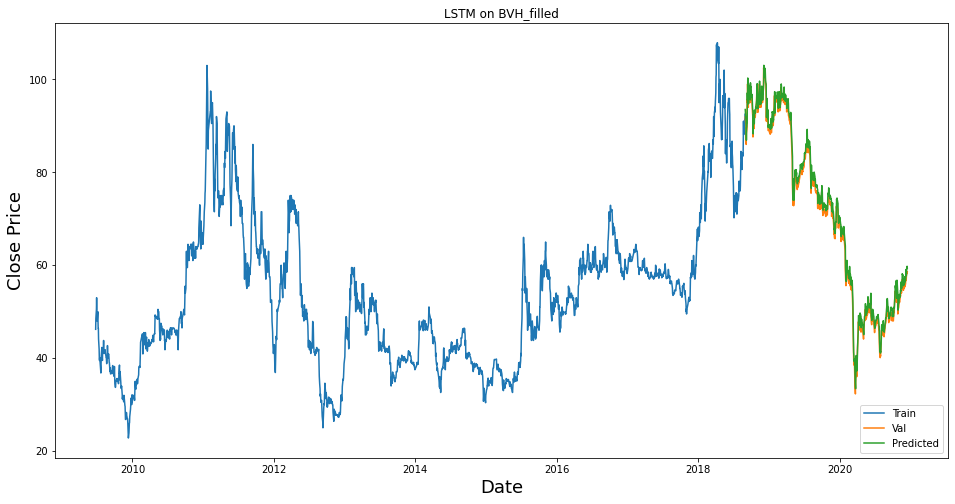

In [18]:
plot_train_and_validation(train_data, valid_data, predictions, title='LSTM on BVH_filled')

In [19]:
rmse=np.sqrt(np.mean(((scaler.inverse_transform(predictions)- scaler.inverse_transform(y_test))**2)))
rmse

1.5129188070832826

## Prediction

In [20]:
def predict(model, scaler, data, time_window, num_of_date):
    x = scaler.transform(data[-time_window:].to_numpy().reshape(-1, 1))[:,0]

    prediction = []

    for i in range(num_of_date):
        y = model.predict(np.reshape(np.array(x), (1, time_window, 1)))
        #if i<3:
        #    print(x)
         #   print(y[0])
        x = np.delete(x, 0)
        x = np.append(x, y[0])
        prediction.append(y[0])
        
    unscaled_prediction = scaler.inverse_transform(prediction)
    
    idx = pd.date_range(data.index[-1], periods=num_of_date+1, freq='1d')[1:]
    return pd.Series(unscaled_prediction[:,0], index=idx)

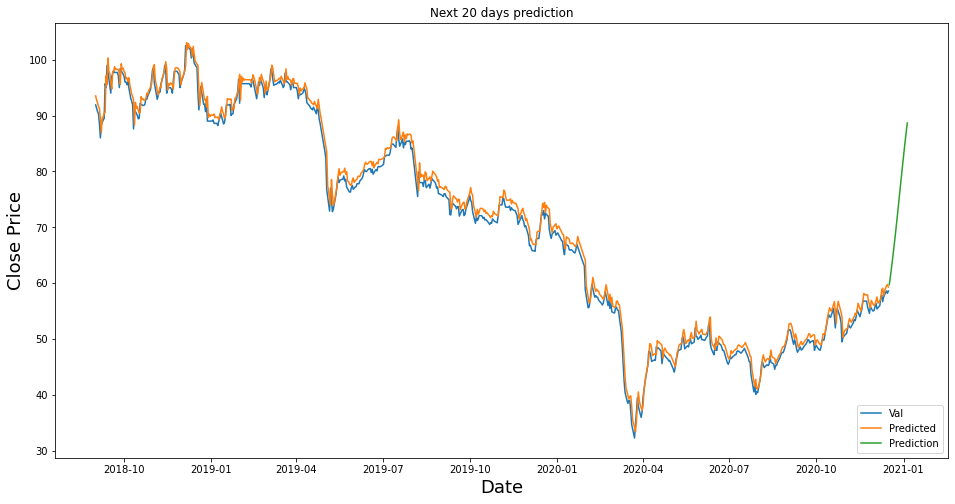

In [21]:
plot_prediction(valid_data, predictions, predict(model, scaler, BVH_filled['Close'], time_window, 20), show = None, title='Next 20 days prediction')

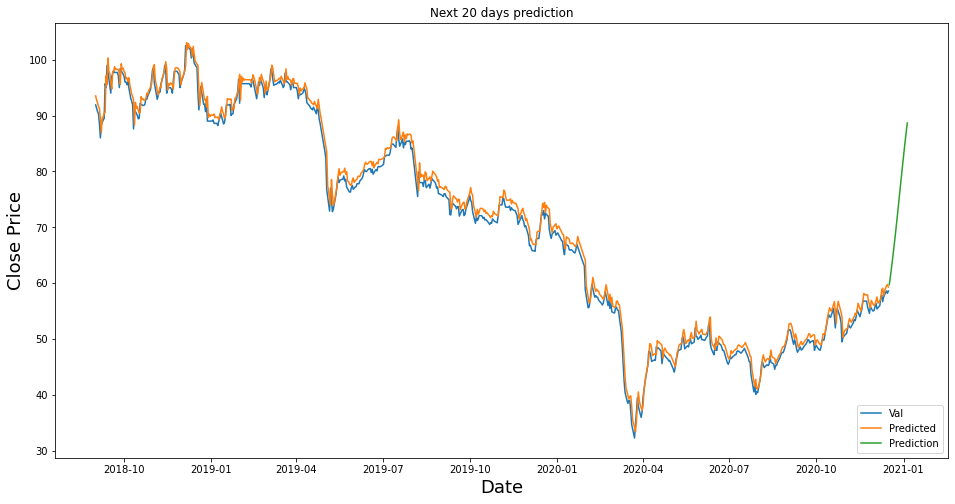

In [22]:
plot_prediction(valid_data, predictions, predict(model, scaler, BVH_filled['Close'], time_window, 20), show = None, title='Next 20 days prediction')

In [23]:
def random_predict(model, scaler, valid_data, time_window, num_of_date, points):
    predictions = []

    for p in points:
        if p < time_window or p > len(valid_data): continue
        predictions.append(predict(model, scaler, valid_data[:p], time_window, num_of_date))
          
    plt.figure(figsize=(16,8))
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(valid_data)
    for p in predictions:
        plt.plot(p, color = 'g')
    plt.legend(['Val', 'Prediction'], loc='lower right')
    plt.show()

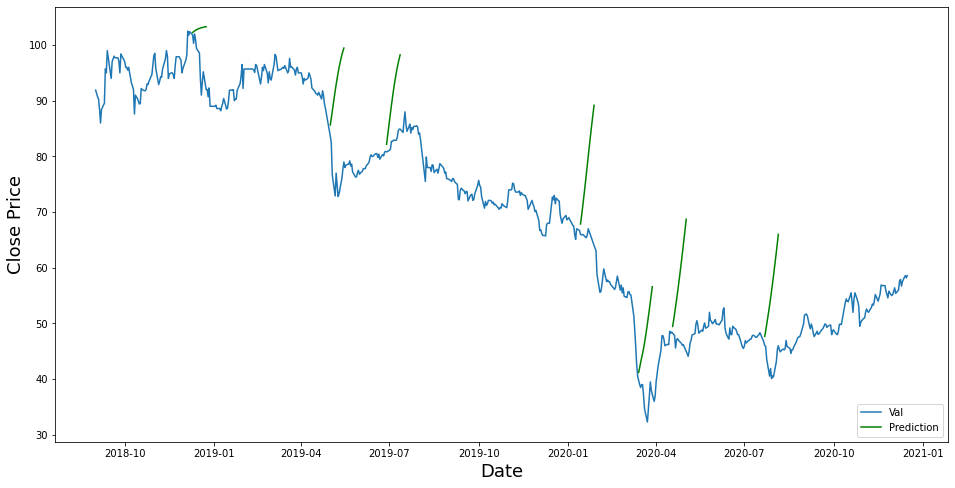

In [24]:
random_predict(model, scaler, valid_data, time_window, 15, [100, 242, 300, 500, 560, 595, 690])

# Ref

https://insights.magestore.com/posts/giai-thuat-time-series-forecasting

https://www.datacamp.com/community/tutorials/lstm-python-stock-market

https://randerson112358.medium.com/stock-price-prediction-using-python-machine-learning-e82a039ac2bb

https://viblo.asia/p/lam-quen-voi-keras-gGJ59mxJ5X2

https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

https://viblo.asia/p/optimizer-hieu-sau-ve-cac-thuat-toan-toi-uu-gdsgdadam-Qbq5QQ9E5D8

https://www.phamduytung.com/blog/2018-10-02-understanding-epoch-batchsize-iterations/